In [1]:
pip install shap Xgboost lightgbm ace_tools

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from tqdm import tqdm
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap

df = pd.read_csv('/home/maia-user/myl/sc/Datasets/processed_total.csv')
df.head()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0.750561,1.416667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,0.750561,1.166667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,0.750561,1.166667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,0.750561,1.166667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,0.755108,1.333333e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [3]:
print(df.shape)
print(df["Label"].value_counts())

(2827876, 79)
Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [4]:

# 假设你已经加载好 df，并完成归一化，包含 "Label" 列
rare_classes = ["Infiltration", "Web Attack � XSS", "Web Attack � Sql Injection", "Heartbleed"]
# 固定 BENIGN 样本数（防止混淆 GAN 效果）
benign_df = df[df["Label"] == "BENIGN"].sample(n=10000, random_state=42)

In [5]:
rare_raw = df[df["Label"].isin(rare_classes)]
df_raw = pd.concat([benign_df, rare_raw], ignore_index=True)

In [6]:
from cgan_module import cgan_augment  

df_single = cgan_augment(df, rare_classes, generate_per_class=500)
rare_single = df_single[df_single["Label"].isin(rare_classes)]
df_single_full = pd.concat([benign_df, rare_single], ignore_index=True)



🔍 正在增强类别: Infiltration
[0/500] Loss_D: 1.3992, Loss_G: 0.7288
[100/500] Loss_D: 0.9492, Loss_G: 1.2067
[200/500] Loss_D: 0.2565, Loss_G: 2.9821
[300/500] Loss_D: 0.1469, Loss_G: 3.6244
[400/500] Loss_D: 1.1667, Loss_G: 1.2108
✅ 生成完成: Infiltration → 500 条

🔍 正在增强类别: Web Attack � XSS
[0/500] Loss_D: 1.3918, Loss_G: 0.7033
[100/500] Loss_D: 0.7820, Loss_G: 1.7038
[200/500] Loss_D: 0.3004, Loss_G: 2.7558
[300/500] Loss_D: 0.9069, Loss_G: 1.1064
[400/500] Loss_D: 0.9925, Loss_G: 1.0669
✅ 生成完成: Web Attack � XSS → 500 条

🔍 正在增强类别: Web Attack � Sql Injection
[0/500] Loss_D: 1.3731, Loss_G: 0.6987
[100/500] Loss_D: 1.1328, Loss_G: 0.9866
[200/500] Loss_D: 0.2343, Loss_G: 3.0074
[300/500] Loss_D: 0.6485, Loss_G: 1.3607
[400/500] Loss_D: 0.9158, Loss_G: 1.2248
✅ 生成完成: Web Attack � Sql Injection → 500 条

🔍 正在增强类别: Heartbleed
[0/500] Loss_D: 1.3951, Loss_G: 0.6801
[100/500] Loss_D: 0.8621, Loss_G: 1.2161
[200/500] Loss_D: 0.1966, Loss_G: 3.0523
[300/500] Loss_D: 0.3348, Loss_G: 2.5501
[400/500] Lo

In [7]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from evaluate import evaluate_pipeline, evaluate_on_original_rare_samples, shap_analysis_global

models = {
    "RandomForest": lambda: RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": lambda: XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
    "LightGBM": lambda: LGBMClassifier()
}

results_all = []

for model_name, model_func in models.items():
    print(f"\n🚀 正在评估模型: {model_name}")

    clf_base, X_base, _, _, le_base = evaluate_pipeline(
        df_raw, f"{model_name} Baseline",
        rare_classes=rare_classes,
        model_cls=model_func
    )

    clf_enh, X_enh, _, _, le_enh = evaluate_pipeline(
        df_single_full, f"{model_name} GAN增强",
        rare_classes=rare_classes,
        model_cls=model_func
    )

    shap_analysis_global(clf_base, X_base, name=f"{model_name}_Baseline")
    shap_analysis_global(clf_enh, X_enh, name=f"{model_name}_Enhanced")
    
    rare_detect_base = evaluate_on_original_rare_samples(clf_base, rare_raw, le_base)
    rare_detect_enh = evaluate_on_original_rare_samples(clf_enh, rare_raw, le_enh)

    compare = rare_detect_base.copy()
    compare = compare.rename(columns={
        "Detected Correctly": "Correct_Before",
        "Recall": "Recall_Before"
    })
    compare["Correct_After"] = rare_detect_enh["Detected Correctly"]
    compare["Recall_After"] = rare_detect_enh["Recall"]
    compare["Model"] = model_name

    results_all.append(compare)

# 合并并展示所有模型结果
import pandas as pd
final_df = pd.concat(results_all, ignore_index=True)
print("\n📊 不同模型在原始 Rare 攻击识别表现对比：")
print(final_df.to_string(index=False))




🚀 正在评估模型: RandomForest

📊 分类报告 (RandomForest Baseline):
                            precision    recall  f1-score   support

                    BENIGN     0.9960    1.0000    0.9980      2000
                Heartbleed     1.0000    1.0000    1.0000         2
              Infiltration     1.0000    0.5714    0.7273         7
Web Attack � Sql Injection     1.0000    0.7500    0.8571         4
          Web Attack � XSS     1.0000    0.9695    0.9845       131

                  accuracy                         0.9963      2144
                 macro avg     0.9992    0.8582    0.9134      2144
              weighted avg     0.9963    0.9963    0.9960      2144


📌 Rare 类别测试集表现：
                     Class  Test Samples  Correctly Predicted  Recall
              Infiltration             7                    4  0.5714
          Web Attack � XSS           131                  127  0.9695
Web Attack � Sql Injection             4                    3  0.7500
                Heartbleed     

 99%|===================| 10587/10720 [00:55<00:00]        

✅ 已保存 SHAP 图像: shap_results/shap_summary_RandomForest_Baseline.png

📊 正在进行 SHAP 分析: RandomForest_Enhanced


 99%|===================| 12629/12720 [01:25<00:00]        

✅ 已保存 SHAP 图像: shap_results/shap_summary_RandomForest_Enhanced.png

🚀 正在评估模型: XGBoost


/home/maia-user/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:25:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 分类报告 (XGBoost Baseline):
                            precision    recall  f1-score   support

                    BENIGN     0.9970    1.0000    0.9985      2000
                Heartbleed     1.0000    0.5000    0.6667         2
              Infiltration     0.8333    0.7143    0.7692         7
Web Attack � Sql Injection     1.0000    0.7500    0.8571         4
          Web Attack � XSS     1.0000    0.9771    0.9884       131

                  accuracy                         0.9967      2144
                 macro avg     0.9661    0.7883    0.8560      2144
              weighted avg     0.9967    0.9967    0.9966      2144


📌 Rare 类别测试集表现：
                     Class  Test Samples  Correctly Predicted  Recall
              Infiltration             7                    5  0.7143
          Web Attack � XSS           131                  128  0.9771
Web Attack � Sql Injection             4                    3  0.7500
                Heartbleed             2                    

/home/maia-user/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:25:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 分类报告 (XGBoost GAN增强):
                            precision    recall  f1-score   support

                    BENIGN     0.9950    1.0000    0.9975      2000
                Heartbleed     1.0000    1.0000    1.0000       102
              Infiltration     1.0000    1.0000    1.0000       107
Web Attack � Sql Injection     1.0000    0.9615    0.9804       104
          Web Attack � XSS     1.0000    0.9740    0.9868       231

                  accuracy                         0.9961      2544
                 macro avg     0.9990    0.9871    0.9929      2544
              weighted avg     0.9961    0.9961    0.9960      2544


📌 Rare 类别测试集表现：
                     Class  Test Samples  Correctly Predicted  Recall
              Infiltration           107                  107  1.0000
          Web Attack � XSS           231                  225  0.9740
Web Attack � Sql Injection           104                  100  0.9615
                Heartbleed           102                  102  

 98%|===================| 10464/10720 [00:29<00:00]        

✅ 已保存 SHAP 图像: shap_results/shap_summary_XGBoost_Baseline.png

📊 正在进行 SHAP 分析: XGBoost_Enhanced


 99%|===================| 12589/12720 [00:46<00:00]        

✅ 已保存 SHAP 图像: shap_results/shap_summary_XGBoost_Enhanced.png

🚀 正在评估模型: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13535
[LightGBM] [Info] Number of data points in the train set: 8576, number of used features: 66
[LightGBM] [Info] Start training from score -0.069526
[LightGBM] [Info] Start training from score -6.859498
[LightGBM] [Info] Start training from score -5.689427
[LightGBM] [Info] Start training from score -6.223510
[LightGBM] [Info] Start training from score -2.800973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

100%|===================| 10704/10720 [01:57<00:00]        

✅ 已保存 SHAP 图像: shap_results/shap_summary_LightGBM_Baseline.png

📊 正在进行 SHAP 分析: LightGBM_Enhanced


100%|===================| 12719/12720 [02:52<00:00]        

✅ 已保存 SHAP 图像: shap_results/shap_summary_LightGBM_Enhanced.png

📊 不同模型在原始 Rare 攻击识别表现对比：
                     Class  Original Sample Count  Correct_Before  Recall_Before  Correct_After  Recall_After        Model
                Heartbleed                     11              11         1.0000             11        1.0000 RandomForest
              Infiltration                     36              33         0.9167             35        0.9722 RandomForest
Web Attack � Sql Injection                     21              20         0.9524             17        0.8095 RandomForest
          Web Attack � XSS                    652             648         0.9939            643        0.9862 RandomForest
                Heartbleed                     11              10         0.9091             11        1.0000      XGBoost
              Infiltration                     36              34         0.9444             36        1.0000      XGBoost
Web Attack � Sql Injection                     21 

In [8]:
# from evaluate import  evaluate_pipeline
# from evaluate import evaluate_on_original_rare_samples

# clf_base, X_base, y_base, rare_base_test = evaluate_pipeline(
#     df_raw, "A. 无增强 Baseline",
#     rare_classes=rare_classes,
#     rare_raw_df=rare_raw
# )

# clf_enh, X_enh, y_enh, rare_enh_test = evaluate_pipeline(
#     df_single_full, "B. 单类增强",
#     rare_classes=rare_classes,
#     rare_raw_df=rare_raw
# )

In [9]:
# # 评估未增强模型对原始攻击识别情况
# rare_detect_base = evaluate_on_original_rare_samples(clf_base, rare_raw，le_base)

# # 评估增强后模型对原始攻击识别情况
# rare_detect_enh = evaluate_on_original_rare_samples(clf_enh, rare_raw,le_enh)

# # 合并结果对比（可选）
# compare = rare_detect_base.copy()
# compare = compare.rename(columns={
#     "Detected Correctly": "Correct_Before",
#     "Recall": "Recall_Before"
# })
# compare["Correct_After"] = rare_detect_enh["Detected Correctly"]
# compare["Recall_After"] = rare_detect_enh["Recall"]

# print(compare.to_string(index=False))

In [10]:
# import shap
# import matplotlib.pyplot as plt
# import numpy as np

# # ✅ 增强前：Baseline 模型 SHAP 分析
# print("🔍 SHAP 分析：Baseline 模型")

# explainer_base = shap.Explainer(clf_base, X_base)
# shap_values_base = explainer_base(X_base, check_additivity=False)

# # 全局特征重要性图（增强前）
# shap.summary_plot(shap_values_base, X_base, max_display=15, show=True)

In [11]:

# # ✅ 增强后：Enhanced 模型 SHAP 分析
# print("\n🔍 SHAP 分析：增强后模型")

# explainer_enh = shap.Explainer(clf_enh, X_enh)
# shap_values_enh = explainer_enh(X_enh, check_additivity=False)

# # 全局特征重要性图（增强后）
# shap.summary_plot(shap_values_enh, X_enh, max_display=15, show=True)

In [12]:
# print(clf_base.classes_)  # 或 clf_enh.classes_
# print(clf_enh.classes_)

### 可视化

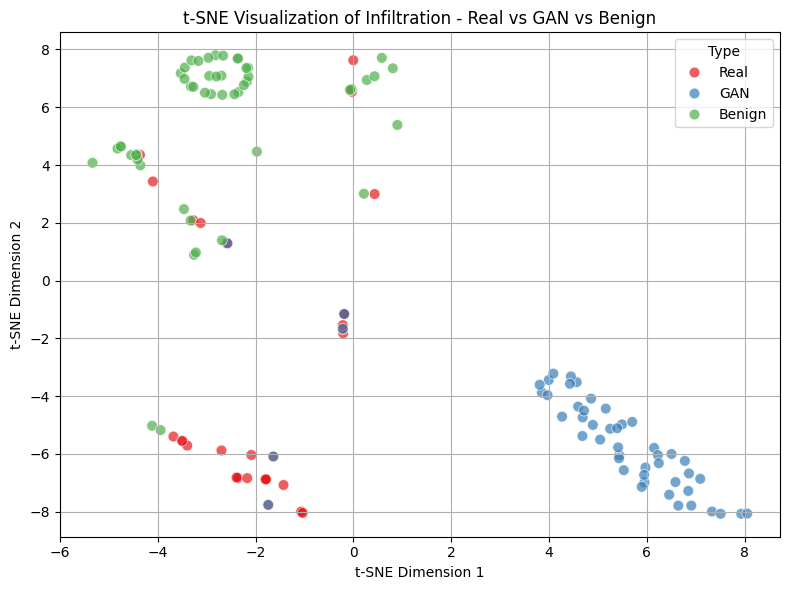

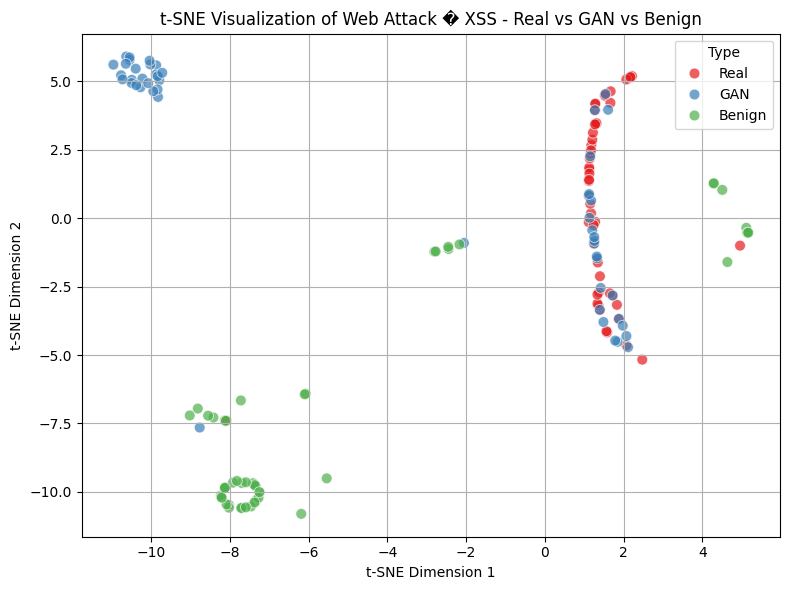

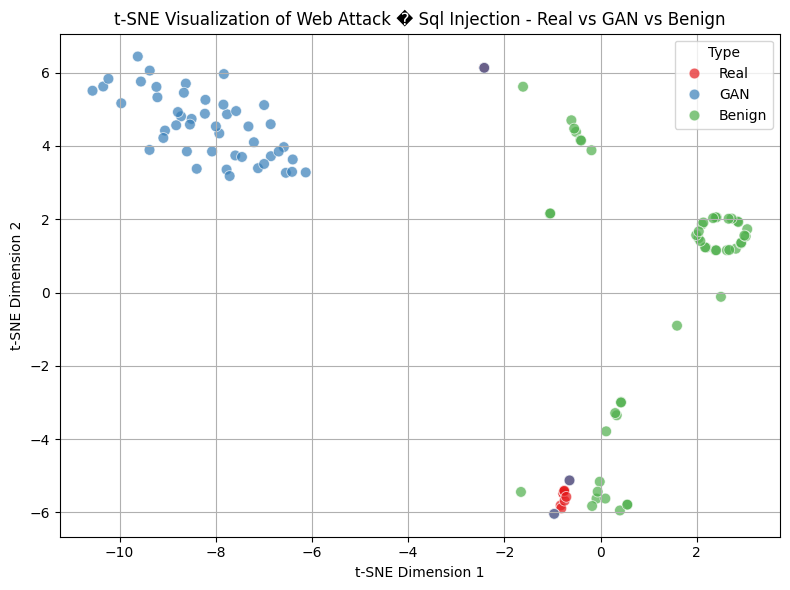

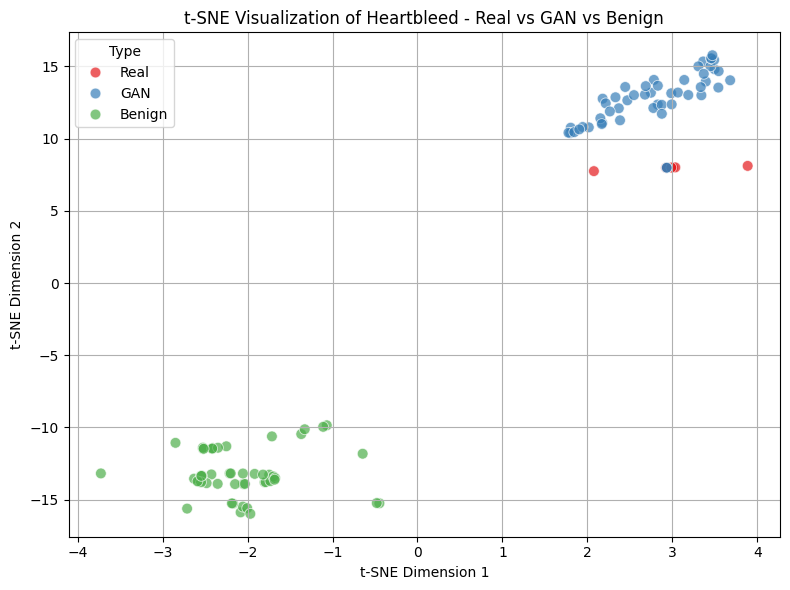

In [13]:
from visualization import plot_tsne_distribution

for a in rare_classes:
    # 按照类别筛选对应的真实样本和 GAN 样本
    real_a = rare_raw[rare_raw["Label"] == a]
    fake_a = rare_single[rare_single["Label"] == a]

    if len(real_a) < 5 or len(fake_a) < 5:
        print(f"⚠️ 样本过少，跳过类别: {a}")
        continue

    # 画出该类别的 t-SNE 图
    plot_tsne_distribution(
        benign_df=benign_df,
        rare_raw=real_a,
        rare_single=fake_a,
        label=a,
        sample_size=50  # 可以调成较小值，避免少样本画不出图
    )



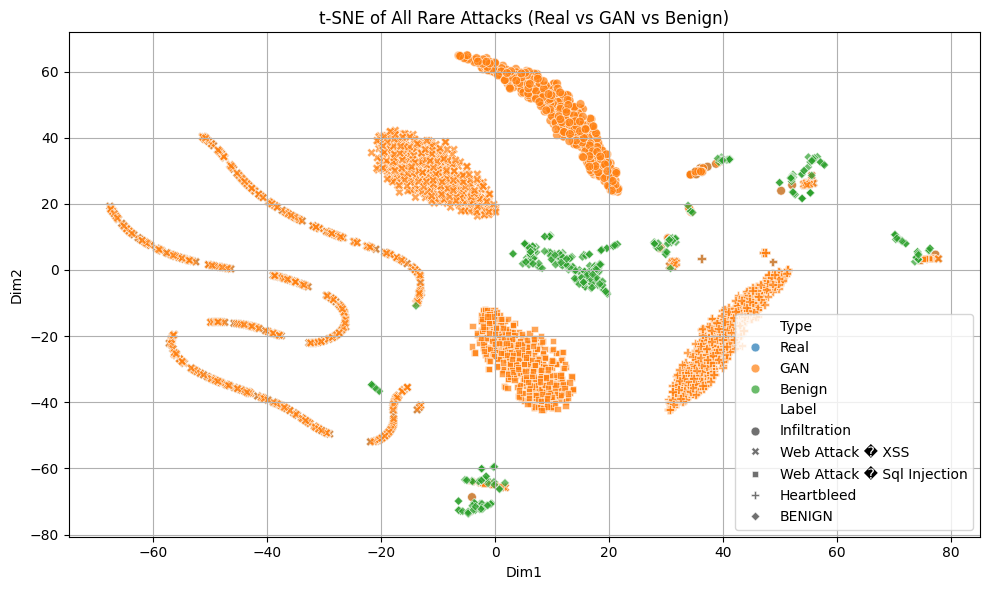

In [14]:
# 所有 rare real 样本
rare_all_real = rare_raw.copy()

# 所有 GAN 生成的样本
rare_all_fake = rare_single.copy()

# Benign 样本随机采样
benign_sample = benign_df.sample(n=500, random_state=42)

# 打标签
rare_all_real["Type"] = "Real"
rare_all_fake["Type"] = "GAN"
benign_sample["Type"] = "Benign"

# 合并数据
tsne_df = pd.concat([rare_all_real, rare_all_fake, benign_sample], ignore_index=True)

# 选择特征列
feature_cols = [col for col in tsne_df.columns if col not in ["Label", "Type"]]

# 降维 + 可视化
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(tsne_df[feature_cols])
df_vis = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
df_vis["Type"] = tsne_df["Type"]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_vis, x="Dim1", y="Dim2", hue="Type", style=tsne_df["Label"], s=40, alpha=0.7)
plt.title("t-SNE of All Rare Attacks (Real vs GAN vs Benign)")
plt.grid(True)
plt.tight_layout()
plt.show()
